# Detector de ataques a API REST con Random Forest + GridSearchCV

Este cuaderno entrena y evalúa un modelo **Random Forest** y **XGBoost** para clasificar peticiones como **normales** o **ataques** a partir de un CSV generado a partir de peticiones a una API rest (`api_logs_ml_ready.csv`).

In [18]:
# Dependencias
import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from sklearn.inspection import permutation_importance

import matplotlib.pyplot as plt

from joblib import dump

CSV_PATH = 'api_logs_ml_ready.csv'  # Ajusta si tu CSV está en otro sitio
assert os.path.exists(CSV_PATH), f'No se encontró el CSV en {CSV_PATH}'
df = pd.read_csv(CSV_PATH)
print('Shape:', df.shape)
df.head()

Shape: (3598, 16)


,timestamp,http_method,endpoint,query_params_count,user_agent,authorization_present,ip_hash,content_length_bytes,num_fields,avg_field_length,failed_auth_attempts_last_10min,suspicious_patterns_detected,statusCode,duration_ms,responseSize,label_attack
0,2025-09-03T06:23:33.316Z,POST,/api/v1/book,0,python-requests/2.32.5,True,ddf72b6676cb429c9adf5335634fdb407bf3319e34499d...,81,3,12.333333,1,"authorization_header_present,suspicious_quotes...",201,28.06,217,0
1,2025-09-03T06:23:33.354Z,GET,/api/v1/book,0,python-requests/2.32.5,True,ddf72b6676cb429c9adf5335634fdb407bf3319e34499d...,0,0,0.000000,1,"authorization_header_present,suspicious_quotes...",200,124.16,110323,0
2,2025-09-03T06:23:34.313Z,POST,/api/v1/auth/signup,0,python-requests/2.32.5,False,ddf72b6676cb429c9adf5335634fdb407bf3319e34499d...,54,2,11.000000,1,suspicious_quotes_or_escape,201,129.52,61,0
3,2025-09-03T06:23:34.449Z,POST,/api/v1/auth/signin,0,python-requests/2.32.5,False,ddf72b6676cb429c9adf5335634fdb407bf3319e34499d...,54,2,11.000000,1,suspicious_quotes_or_escape,201,170.61,251,0
4,2025-09-03T06:23:34.627Z,POST,/api/v1/book,0,python-requests/2.32.5,True,ddf72b6676cb429c9adf5335634fdb407bf3319e34499d...,81,3,12.333333,1,"authorization_header_present,suspicious_quotes...",201,12.80,217,0


## 1) Análisis exploratorio rápido

In [19]:

# Tipos y valores faltantes
display(df.dtypes)
display(df.isna().mean().sort_values(ascending=False).head(20))

# Distribución de la etiqueta
if 'label_attack' not in df.columns:
    raise ValueError("No se encontró la columna 'label_attack' en el CSV. Asegúrate de que existe y es 0/1.")
print(df['label_attack'].value_counts(dropna=False))
df['label_attack'].value_counts(normalize=True).mul(100).round(2)


timestamp                           object
http_method                         object
endpoint                            object
query_params_count                   int64
user_agent                          object
authorization_present                 bool
ip_hash                             object
content_length_bytes                 int64
num_fields                           int64
avg_field_length                   float64
failed_auth_attempts_last_10min      int64
suspicious_patterns_detected        object
statusCode                           int64
duration_ms                        float64
responseSize                         int64
label_attack                         int64
dtype: object

timestamp                          0.0
http_method                        0.0
endpoint                           0.0
query_params_count                 0.0
user_agent                         0.0
authorization_present              0.0
ip_hash                            0.0
content_length_bytes               0.0
num_fields                         0.0
avg_field_length                   0.0
failed_auth_attempts_last_10min    0.0
suspicious_patterns_detected       0.0
statusCode                         0.0
duration_ms                        0.0
responseSize                       0.0
label_attack                       0.0
dtype: float64

label_attack
0    2398
1    1200
Name: count, dtype: int64


label_attack
0    66.65
1    33.35
Name: proportion, dtype: float64

## 2) Selección de variables

In [20]:
# Definimos columnas candidatas
potential_features = [
    'http_method',
    'endpoint',
    'query_params_count',
    #'user_agent',
    'authorization_present',
    'ip_hash',
    'content_length_bytes',
    'num_fields',
    'avg_field_length',
    'failed_auth_attempts_last_10min',
    'suspicious_patterns_detected',
    'statusCode',
    'duration_ms',
    'responseSize'
]

existing_features = [c for c in potential_features if c in df.columns]
missing = set(potential_features) - set(existing_features)
print("Usando features:", existing_features)
if missing:
    print("Aviso: no se encontraron estas columnas y serán ignoradas:", missing)

X = df[existing_features].copy()
y = df['label_attack'].astype(int)

# Convertimos tipos: booleanos a int, listas/strings a string
for col in X.columns:
    if X[col].dtype == bool:
        X[col] = X[col].astype(int)
    if X[col].dtype == object:
        X[col] = X[col].astype(str)


Usando features: ['http_method', 'endpoint', 'query_params_count', 'authorization_present', 'ip_hash', 'content_length_bytes', 'num_fields', 'avg_field_length', 'failed_auth_attempts_last_10min', 'suspicious_patterns_detected', 'statusCode', 'duration_ms', 'responseSize']


## 3) Split entrenamiento / validación

In [21]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
X_train.shape, X_test.shape


((2698, 13), (900, 13))

## 4) Pipeline de preprocesado + modelo con GridSearchCV

In [22]:
# Definimos columnas numéricas y categóricas de forma automática
numeric_cols = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
categorical_cols = [c for c in X.columns if c not in numeric_cols]

preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', 'passthrough', numeric_cols)
    ]
)

clf = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced')

pipe = Pipeline(steps=[('prep', preprocess), ('rf', clf)])

# Grid de hiperparámetros
param_grid = {
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': [None, 10, 20],
    'rf__min_samples_split': [2, 5],
    'rf__min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    pipe,
    param_grid,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)
print("Mejor score medio en CV:", grid_search.best_score_)

best_pipe = grid_search.best_estimator_


Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV] END rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time=   0.6s
[CV] END rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time=   0.6s
[CV] END rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time=   0.6s
[CV] END rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=200; total time=   1.2s
[CV] END rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=200; total time=   1.1s
[CV] END rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=200; total time=   1.1s
[CV] END rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=100; total time=   0.6s
[CV] END rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=300; total

## 5) Evaluación del mejor modelo


Classification report:

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       600
           1     1.0000    1.0000    1.0000       300

    accuracy                         1.0000       900
   macro avg     1.0000    1.0000    1.0000       900
weighted avg     1.0000    1.0000    1.0000       900

Matriz de confusión:
 [[600   0]
 [  0 300]]
ROC-AUC: 1.0000


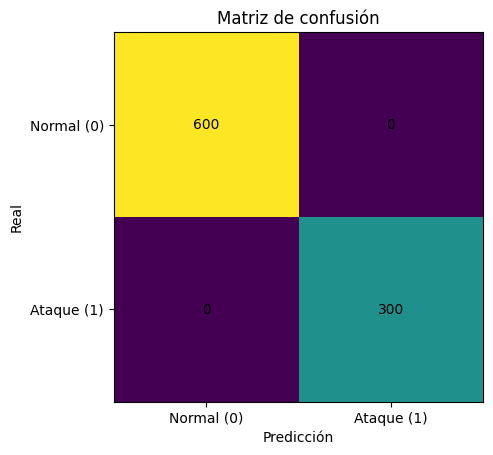

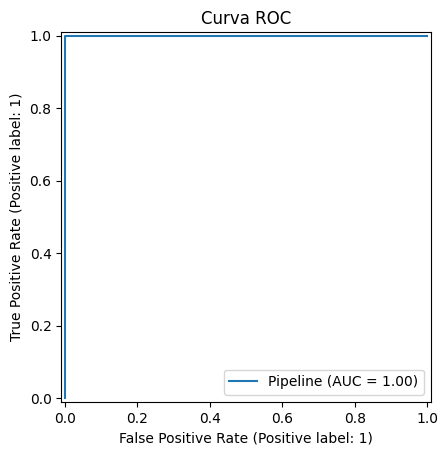

In [23]:

y_pred = best_pipe.predict(X_test)
y_proba = best_pipe.predict_proba(X_test)[:, 1]

print("\nClassification report:\n")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred)
print("Matriz de confusión:\n", cm)

try:
    auc = roc_auc_score(y_test, y_proba)
    print(f"ROC-AUC: {auc:.4f}")
except Exception as e:
    print("No se pudo calcular ROC-AUC:", e)

# Plot matriz de confusión
fig, ax = plt.subplots()
im = ax.imshow(cm)
ax.set_title('Matriz de confusión')
ax.set_xlabel('Predicción')
ax.set_ylabel('Real')
ax.set_xticks([0,1]); ax.set_yticks([0,1])
ax.set_xticklabels(['Normal (0)', 'Ataque (1)'])
ax.set_yticklabels(['Normal (0)', 'Ataque (1)'])
for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, int(val), ha='center', va='center')
plt.show()

# Plot curva ROC
try:
    RocCurveDisplay.from_estimator(best_pipe, X_test, y_test)
    plt.title('Curva ROC')
    plt.show()
except Exception as e:
    print("No se pudo trazar la curva ROC:", e)


## 7) Guardar el pipeline entrenado

In [25]:

MODEL_PATH = 'random_forest_api_attack_detector_tuned.joblib'
dump(best_pipe, MODEL_PATH)
print(f'Modelo guardado en: {MODEL_PATH}')


Modelo guardado en: random_forest_api_attack_detector_tuned.joblib


# Clasificación con XGBoost 

## 1) Configuración

In [26]:
DATA_PATH = "api_logs_ml_ready_3.csv"
OUTPUT_DIR = "outputs_xgboost"
TARGET_COL = "label_attack"

RANDOM_STATE = 42
N_JOBS = -1

from pathlib import Path
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

print(f"Ruta de datos: {DATA_PATH}")
print(f"Target: {TARGET_COL}")
print(f"Salida: {OUTPUT_DIR}")

Ruta de datos: api_logs_ml_ready_3.csv
Target: label_attack
Salida: outputs_xgboost


## 2) Importación de librerías incluido XGBoost

In [27]:
import warnings
warnings.filterwarnings("ignore")

import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay)
from sklearn.inspection import permutation_importance

from joblib import dump
from xgboost import XGBClassifier

## 3) Selección de columnas de entrada y objetivo

In [28]:
# Detectar columnas numéricas y categóricas
numeric_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
categorical_cols = [c for c in df.columns if c not in numeric_cols]

# Target
if TARGET_COL in df.columns:
    y = df[TARGET_COL]
    X = df.drop(columns=[TARGET_COL])
    # Actualizar listas quitando target si quedó en ellas
    if TARGET_COL in numeric_cols: numeric_cols.remove(TARGET_COL)
    if TARGET_COL in categorical_cols: categorical_cols.remove(TARGET_COL)
else:
    y = None
    X = df.copy()
    print(f"Aviso: TARGET_COL='{TARGET_COL}' no existe en el DataFrame. Define correctamente la variable objetivo.")
    
print(f"Numéricas ({len(numeric_cols)}):", numeric_cols[:10], "..." if len(numeric_cols)>10 else "")
print(f"Categóricas ({len(categorical_cols)}):", categorical_cols[:10], "..." if len(categorical_cols)>10 else "")

Numéricas (9): ['query_params_count', 'authorization_present', 'content_length_bytes', 'num_fields', 'avg_field_length', 'failed_auth_attempts_last_10min', 'statusCode', 'duration_ms', 'responseSize'] 
Categóricas (6): ['timestamp', 'http_method', 'endpoint', 'user_agent', 'ip_hash', 'suspicious_patterns_detected'] 


## 4) Partición *train/test*

In [29]:
if y is not None:
    stratify = y if (y.nunique() <= 20) else None
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=stratify
    )
    print("Shapes:", X_train.shape, X_test.shape)
else:
    X_train = X_test = y_train = y_test = None
    print("No hay target; no se puede continuar con el entrenamiento supervisado.")

Shapes: (2878, 15) (720, 15)


## 5) Preprocesamiento

In [30]:
numeric_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore")),
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipeline, numeric_cols),
        ("cat", categorical_pipeline, categorical_cols),
    ],
    remainder="drop",
    sparse_threshold=0.3
)

def get_feature_names(pre):
    output_features = []
    for name, trans, cols in pre.transformers_:
        if name == "remainder": 
            continue
        if hasattr(trans, "get_feature_names_out"):
            feats = trans.get_feature_names_out(cols if isinstance(cols, list) else None)
            output_features.extend(feats)
        else:
            if isinstance(cols, list): output_features.extend(cols)
            else: output_features.append(cols)
    return np.array(output_features)


## 7) XGBoost + búsqueda de hiperparámetros

In [31]:
best_xgb = None
cv_results_ = None
    
# scale_pos_weight ≈ Negativos/Positivos (robusto a desbalanceo)
pos_label = sorted(y_train.unique())[-1]  # intento: mayor es positiva si son [0,1]
n_pos = (y_train == pos_label).sum()
n_neg = (y_train != pos_label).sum()
scale_pos_weight = max(n_neg / max(n_pos, 1), 1.0)
objective = "binary:logistic"
eval_metric = "auc"
scoring = "f1"

    
xgb = XGBClassifier(
    objective=objective,
    eval_metric=eval_metric,
    n_estimators=400,
    learning_rate=0.05,
    tree_method="hist",
    subsample=0.9,
    colsample_bytree=0.9,
    max_depth=6,
    min_child_weight=1,
    reg_lambda=1.0,
    n_jobs=N_JOBS,
    random_state=RANDOM_STATE,
    scale_pos_weight=scale_pos_weight,
    # NOTA: usamos OneHotEncoder, por eso no habilitamos categóricas nativas
    enable_categorical=False
)
    
pipe = Pipeline(steps=[("pre", preprocessor), ("xgb", xgb)])
    
param_dist = {
    "xgb__n_estimators": [300, 400, 600, 800],
    "xgb__max_depth": [3, 4, 6, 8],
    "xgb__learning_rate": [0.02, 0.05, 0.1],
    "xgb__subsample": [0.7, 0.85, 1.0],
    "xgb__colsample_bytree": [0.7, 0.85, 1.0],
    "xgb__min_child_weight": [1, 3, 5],
    "xgb__reg_lambda": [1.0, 1.5, 2.0],
    "xgb__gamma": [0, 0.5, 1.0],
}
    
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
search = RandomizedSearchCV(
    pipe, param_dist, n_iter=20, scoring=scoring, cv=cv,
    n_jobs=N_JOBS, random_state=RANDOM_STATE, verbose=2, refit=True
)
search.fit(X_train, y_train)
best_xgb = search.best_estimator_
cv_results_ = search.cv_results_
    
print("Mejores hiperparámetros:", search.best_params_)
print("Mejor score medio (CV):", search.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END xgb__colsample_bytree=0.85, xgb__gamma=1.0, xgb__learning_rate=0.05, xgb__max_depth=8, xgb__min_child_weight=1, xgb__n_estimators=800, xgb__reg_lambda=2.0, xgb__subsample=0.85; total time=   1.2s
[CV] END xgb__colsample_bytree=0.85, xgb__gamma=1.0, xgb__learning_rate=0.05, xgb__max_depth=8, xgb__min_child_weight=1, xgb__n_estimators=800, xgb__reg_lambda=2.0, xgb__subsample=0.85; total time=   1.2s
[CV] END xgb__colsample_bytree=0.85, xgb__gamma=1.0, xgb__learning_rate=0.05, xgb__max_depth=8, xgb__min_child_weight=1, xgb__n_estimators=800, xgb__reg_lambda=2.0, xgb__subsample=0.85; total time=   1.2s
[CV] END xgb__colsample_bytree=0.85, xgb__gamma=1.0, xgb__learning_rate=0.05, xgb__max_depth=8, xgb__min_child_weight=1, xgb__n_estimators=800, xgb__reg_lambda=2.0, xgb__subsample=0.85; total time=   1.2s
[CV] END xgb__colsample_bytree=0.7, xgb__gamma=0, xgb__learning_rate=0.05, xgb__max_depth=8, xgb__min_child_weight=5, 

## 8) Evaluación: classification report, matriz de confusión y ROC-AUC


Classification report:

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       480
           1     1.0000    1.0000    1.0000       240

    accuracy                         1.0000       720
   macro avg     1.0000    1.0000    1.0000       720
weighted avg     1.0000    1.0000    1.0000       720

Matriz de confusión:
 [[480   0]
 [  0 240]]
ROC-AUC: 1.0000


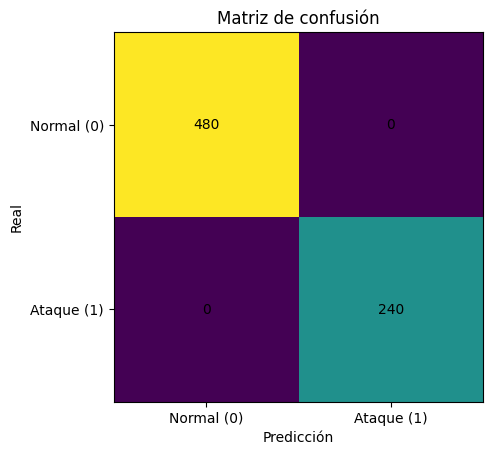

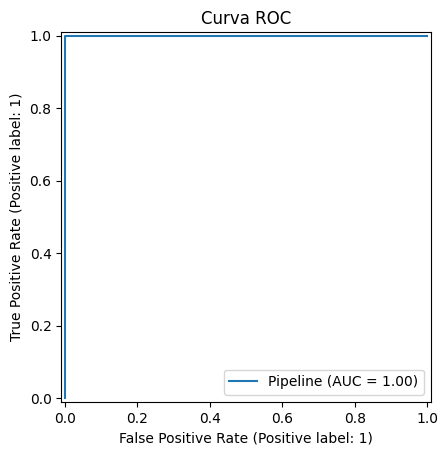

In [32]:
y_pred = best_xgb.predict(X_test)
y_proba = best_xgb.predict_proba(X_test)[:, 1]

print("\nClassification report:\n")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred)
print("Matriz de confusión:\n", cm)

try:
    auc = roc_auc_score(y_test, y_proba)
    print(f"ROC-AUC: {auc:.4f}")
except Exception as e:
    print("No se pudo calcular ROC-AUC:", e)

# Plot matriz de confusión
fig, ax = plt.subplots()
im = ax.imshow(cm)
ax.set_title('Matriz de confusión')
ax.set_xlabel('Predicción')
ax.set_ylabel('Real')
ax.set_xticks([0,1]); ax.set_yticks([0,1])
ax.set_xticklabels(['Normal (0)', 'Ataque (1)'])
ax.set_yticklabels(['Normal (0)', 'Ataque (1)'])
for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, int(val), ha='center', va='center')
plt.show()

# Plot curva ROC
try:
    RocCurveDisplay.from_estimator(best_xgb, X_test, y_test)
    plt.title('Curva ROC')
    plt.show()
except Exception as e:
    print("No se pudo trazar la curva ROC:", e)

Guardamos el pipeline entrenado

In [33]:
MODEL_PATH = 'xgboost_api_attack_detector_tuned.joblib'
dump(best_xgb, MODEL_PATH)
print(f'Modelo guardado en: {MODEL_PATH}')

Modelo guardado en: xgboost_api_attack_detector_tuned.joblib
